# Supervised Learning with toybrains dataset using Lightning
> Dev log (format < Date > | <Author(s)> )  
> - Developed: 30 May 2023 | JiHoon Kim <br>
> - Tested and improved: 17 July 2023 | Roshan Rane <br>

## Installing Libraries

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# check GPUs available and memory
! gpustat

cuda02                      Tue Jul 18 11:23:15 2023  470.199.02
[0] NVIDIA GeForce RTX 3090 | 30°C,   0 % | 14441 / 24268 MB | moritz(2267M) tomasz(5651M) tomasz(813M) tomasz(2133M) tomasz(3569M) gdm(4M)
[1] NVIDIA GeForce RTX 3090 | 69°C, 100 % | 22705 / 24268 MB | sam(22697M) gdm(4M)
[2] NVIDIA GeForce RTX 3090 | 29°C,   0 % |     8 / 24268 MB | gdm(4M)
[3] NVIDIA GeForce RTX 3090 | 31°C,   0 % |     8 / 24268 MB | gdm(4M)


In [3]:
# standard python packages
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

import torch
# import monai
import lightning as L
from lightning.pytorch.loggers import CSVLogger

In [4]:
# add custom imports
# (TODO) refactoring needed
from utils.dataset import generate_dataset
from utils.DLutils import (
    get_dataset_loaders,
    ToyBrainsDataset, LightningModel,
    PyTorchMLP, LogisticRegression, viz_batch
)

## Generating the synthetic dataset

In [5]:
# ! python create_toybrains.py -d -n 10000

## Loading the DataLoader

In [6]:
# set random seed
seed = 42
torch.manual_seed(seed) 
np.random.seed(seed)
random.seed(seed)
# set the seed for Lightning
L.seed_everything(seed)

Global seed set to 42


42

In [7]:
# dataset
DATA_DIR = 'toybrains30k/'
raw_csv_path = DATA_DIR+'toybrains_n30000.csv'
data_df = pd.read_csv(raw_csv_path).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 34 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   subjectID                30000 non-null  int64  
 1   _gen_brain_vol-radminor  30000 non-null  float64
 2   _gen_brain_vol-radmajor  30000 non-null  float64
 3   gen_brain_thick          30000 non-null  float64
 4   gen_brain_int            30000 non-null  float64
 5   gen_border_int           30000 non-null  object 
 6   gen_vent_thick           30000 non-null  float64
 7   gen_shape-top_curv       30000 non-null  float64
 8   gen_shape-top_int        30000 non-null  object 
 9   _gen_shape-top_vol-rad   30000 non-null  float64
 10  gen_shape-midr_curv      30000 non-null  float64
 11  gen_shape-midr_int       30000 non-null  object 
 12  _gen_shape-midr_vol-rad  30000 non-null  float64
 13  gen_shape-midl_curv      30000 non-null  float64
 14  gen_shape-midl_int    

In [8]:
# choose a target label among the available columns in the table
label = 'lblbin_shp-vol'

In [9]:
# split the dataset for training, validation, and test from raw dataset
df_train, df_val, df_test = generate_dataset(raw_csv_path, label, seed)
print(f" Training data split = {len(df_train)} \n Validation data split = {len(df_val)} \n Test data split = {len(df_test)}")

 Training data split = 24000 
 Validation data split = 3000 
 Test data split = 3000


### Estimate the baselines
1. [TODO] Accuracy when predicting the most frequent class label:
   ```python
    for images, labels in loader:
        counter.update(labels.tolist())
    print(f"\nLabel distribution: {sorted(counter.items())}")
    
    majority_class = counter.most_common(1)[0]
    print(f"Majority class: {majority_class[0]}")
    
    baseline_acc = majority_class[1] / sum(counter.values())
    print(f"Accuracy when always predicting the majority class: {baseline_acc:.2f} ({baseline_acc*100:.2f}%)")
    ```

3. [TODO] best expected accuracy from predicting directly from the image attributes:
4. [TODO] best expected accuracy after deconfounding

In [11]:
# prepare the dataLaoder
train_loader, val_loader, test_loader = get_dataset_loaders(
                    data_split_dfs=[df_train, df_val, df_test],
                    data_dir=DATA_DIR+'/images',
                    batch_size=16, shuffle=True, 
                    num_workers=0, transform=[])

### Vizualize the Batch on DataLoader

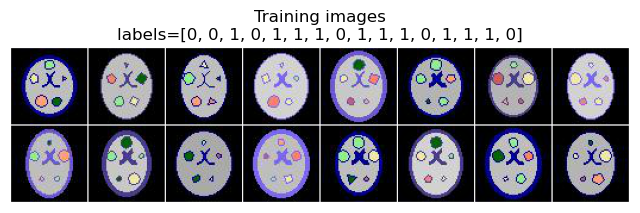

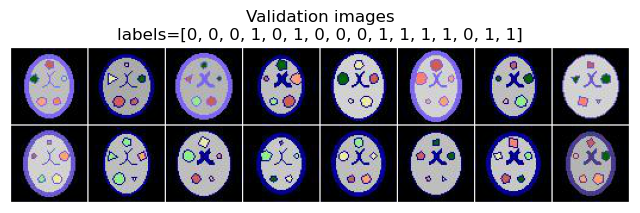

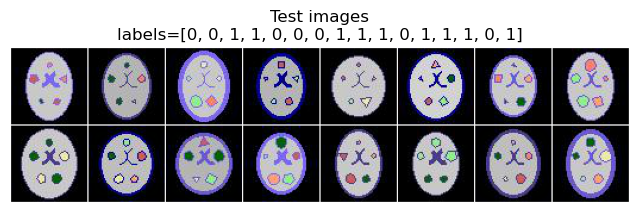

In [27]:
viz_batch(train_loader, title="Training images", debug=True)
viz_batch(val_loader, title="Validation images", debug=True)
viz_batch(test_loader, title="Test images", debug=True)

## Predictive Modeling

Tasks : [baseline model](https://github.com/RoshanRane/toybrains/issues/1)

In [28]:
# multi layer perceprton implementation
pytorch_model = PyTorchMLP(num_features=12288, num_classes=2)

In [29]:
# set denseNet model as default

# pytorch_model = monai.networks.nets.DenseNet121(spatial_dims=2, in_channels=3, out_channels=2)

In [30]:
# chcek the available model in resnet

# entrypoints = torch.hub.list('pytorch/vision:v0.13.0', force_reload=True)
# for e in entrypoints:
#     if "resnet" in e:
#         print(e)

In [31]:
# resnet implementation

# pytorch_model = torch.hub.load('pytorch/vision:v0.13.0', 'resnet18', weights='IMAGENET1K_V1')

# for param in pytorch_model.parameters():
#     param.requires_grad = False
    
# pytorch_model.fc = torch.nn.Linear(512, 2)

In [32]:
# logistic regression implmententation

# pytorch_model = LogisticRegression(num_features=12288)

In [ ]:
# set lightning model
lightning_model = LightningModel(model=pytorch_model, learning_rate=0.05)

In [ ]:
trainer = L.Trainer(
    max_epochs=10,
    accelerator="gpu",
    devices=[0],
    logger=CSVLogger(save_dir="logs/", name="my_model"),
    deterministic=True
)

In [ ]:
trainer.fit(
    model=lightning_model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader,
)

In [ ]:
train_acc = trainer.test(dataloaders=train_loader)[0]["accuracy"]
val_acc = trainer.test(dataloaders=val_loader)[0]["accuracy"]
test_acc = trainer.test(dataloaders=test_loader)[0]["accuracy"]

print(
    f"Train Acc {train_acc*100:.2f}%"
    f" | Val Acc {val_acc*100:.2f}%"
    f" | Test Acc {test_acc*100:.2f}%"
)

`Bug on below code: if you use mlti gpu then you may found the several version_X generated on one run.` <br>
Please specify correct metrics.csv which contain all. <br>
(TODO) Refactoring the code on result plot

In [ ]:
metrics = pd.read_csv(f"logs/my_model/version_4/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "val_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)
df_metrics[["train_acc", "val_acc"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
)

plt.show()

In [ ]:
PATH = "lightning.pt"
torch.save(pytorch_model.state_dict(), PATH)